In [2]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import ee
import geopandas as gpd

ee.Authenticate()
ee.Initialize(project='ee-chrismihiar', opt_url='https://earthengine-highvolume.googleapis.com')


# FIA Survey Units

In [29]:
# read all files in the folder and bind them together
# the files are found in FIA_REFERENCE and follow the pattern *_COUNTY.csv
# the first two characters of the file name are the state abbreviation

path = '../FIADB_REFERENCE'
refFiles = glob.glob(os.path.join(path, "*_COUNTY.csv"))

dataframes = []

for f in refFiles:
    df = pd.read_csv(f, encoding='latin1')
    df['fips'] = df['STATECD'].astype(str).str.zfill(2).add(
        df['COUNTYCD'].astype(str).str.zfill(3))
    df = df[['fips', 'UNITCD']]
    df = df.rename(columns={'UNITCD': 'unitcd'})
    dataframes.append(df)

fiaUnits = pd.concat(dataframes, ignore_index=True).sort_values('fips')
fiaUnits['unitcd'] = fiaUnits['unitcd'].astype(str).str.zfill(2)
fiaUnits

,fips,unitcd
613,01001,03
601,01003,01
614,01005,03
634,01007,04
643,01009,05
...,...,...
429,55133,05
391,55135,03
392,55137,03
430,55139,05


# County and Region Names and Codes

In [9]:
geoRef = pd.read_csv('../data/georef.csv', encoding='latin1')
geoRef['fips'] = geoRef['county_fips'].astype(str).str.zfill(5)
geoRef = geoRef[['fips', 'county_name',
                'state_name',
                'state_abbr',
                'subregion_name',
                'region_name',
                'mer100']]

# Verify the changes
geoRef.head()

,fips,county_name,state_name,state_abbr,subregion_name,region_name,mer100
0,01001,Autauga,Alabama,AL,South Central,South,east
1,01003,Baldwin,Alabama,AL,South Central,South,east
2,01005,Barbour,Alabama,AL,South Central,South,east
3,01007,Bibb,Alabama,AL,South Central,South,east
4,01009,Blount,Alabama,AL,South Central,South,east


In [20]:
# read in tms county crosswalk
# column names should be fips, statecd, priceRegion.
# where priceRegion state fip and region code.

tmsCounties = pd.read_csv('../data/tmsCounties.csv')
tmsCounties = tmsCounties.rename(columns={'STTMS': 'priceRegion',
                                          'FIPS Code': 'fips'})
tmsCounties['fips'] = tmsCounties['fips'].astype(str).str.zfill(5)
tmsCounties['statecd'] = tmsCounties['fips'].str.slice(0, 2)
tmsCounties['priceRegion'] = tmsCounties['priceRegion'].astype(str).str.zfill(5)
tmsCounties['priceRegion'] = tmsCounties['priceRegion'].str[-2:]
tmsCounties = tmsCounties[['fips', 'statecd', 'priceRegion']]

tmsCounties

,fips,statecd,priceRegion
0,01001,01,01
1,01003,01,02
2,01005,01,02
3,01007,01,01
4,01009,01,01
...,...,...,...
1039,51550,51,02
1040,51650,51,02
1041,51700,51,02
1042,51800,51,02


In [26]:
# read in tmn county crosswalk
# column names should be fips, statecd, priceRegion.
# where priceRegion state fip and region code.

tmnCounties = pd.read_csv('../data/tmnCounties.csv')
tmnCounties = tmnCounties.rename(columns={'County FIPS Code': 'fips',
                                          'State FIPS Code': 'statecd'})
tmnCounties['fips'] = tmnCounties['fips'].astype(str).str.zfill(5)
tmnCounties['statecd'] = tmnCounties['statecd'].astype(str).str.zfill(2)
tmnCounties['priceRegion'] = tmnCounties['Region'].str[-1:]
tmnCounties['priceRegion'] = tmnCounties['priceRegion'].str.zfill(2)
tmnCounties = tmnCounties[['fips', 'statecd', 'priceRegion']]

tmnCounties

#priceRegions = pd.concat([tmsCounties, tmnCounties], ignore_index=True)

,fips,statecd,priceRegion
0,26001,26,01
1,26007,26,01
2,26009,26,01
3,26011,26,01
4,26017,26,01
...,...,...,...
180,55113,55,03
181,55119,55,03
182,55121,55,03
183,55129,55,03


In [30]:
# concatenate the dataframes

priceRegions = pd.concat([tmsCounties, tmnCounties], ignore_index=True)

# merge with fia survey unit codes

priceRegions = priceRegions.merge(fiaUnits, on='fips', how='left')
priceRegions

,fips,statecd,priceRegion,unitcd
0,01001,01,01,03
1,01003,01,02,01
2,01005,01,02,03
3,01007,01,01,04
4,01009,01,01,05
...,...,...,...,...
1224,55113,55,03,02
1225,55119,55,03,02
1226,55121,55,03,04
1227,55129,55,03,02


# Match price regions to counties

In [21]:
# create a crosswalk table between fips and priceRegion

priceRegionSouth = {'TX1': ['Fannin', 'Lamar', 'Red River', 'Bowie', 'Cass',
                         'Morris', 'Titus', 'Franklin', 'Hopkins', 'Delta',
                         'Hunt', 'Rains', 'Kaufman', 'Van Zandt', 'Wood',
                         'Camp', 'Upshur', 'Smith', 'Gregg', 'Harrison',
                         'Marion', 'Henderson', 'Navaarro', 'Rusk', 'Panola'],
                'TX2': ['Limestone', 'Freestone', 'Anderson', 'Houston',
                         'Cherokee', 'Nacogdoches', 'Shelby', 'San Augustine',
                         'Sabine', 'Angelina', 'Trinity', 'Polk', 'Tyler',
                         'Jasper', 'Newton', 'Hardin', 'Orange', 'Robertson',
                        'Brazos', 'Washington', 'Austin', 'Wharton', 'Matagorda',
                        'Madison', 'Walker', 'San Jacinto', 'Liberty', 'Chambers',
                        'Jefferson', 'Harris', 'Montgomery', 'Galveston', 'Fort Bend',
                        'Brazoria'],
                'LA1': ['Caddo', 'Bossier', 'Webster', 'Claiborne', 'Bienville',
                        'Red River', 'De Soto', 'Sabine', 'Natchitoches', 'Winn',
                        'Grant', 'Rapides', 'Vernon', 'Beauregard', 'Allen',
                        'Calcasieu', 'Jefferson Davis', 'Union', 'Lincoln',
                        'Jackson', 'Caldwell', 'La Salle', 'Morehouse', 'Richland',
                        'West Carroll', 'East Carroll', 'Madison', 'Tensas',
                        'Concordia', 'Catahoula', 'Franklin', 'Evangeline',
                        'Avoyelles'],
                'LA2': ['St. Landry', 'Pointe Coupee', 'West Feliciana', 'Acadia',
                        'Vermillion', 'Iberia', 'St. Martin', 'Lafayette',
                        'St. Mary', 'Assumption', 'St. James', 'St. John the Baptist',
                        'St. Charles', 'Jefferson', 'Orleans', 'St. Bernard',
                        'Plaquemines', 'St. Tammany', 'Tangipahoa', 'Washington',
                        'St. Helena', 'Livingston', 'Ascension', 'Terrabonne',
                        'Lafourche', 'Iberville', 'West Baton Rouge', 'East Baton Rouge',
                        'East Feliciana'],
                'MS1': ['Desoto', 'Tunica', 'Tate', 'Marshall', 'Lafayette',
                        'Panola', 'Quitman', 'Coahoma', 'Bolivar', 'Sunflower',
                        'Washington', 'Humphreys', 'Holmes', 'Yazoo', 'Issaquena',
                        'Sharkey', 'Benton', 'Tippah', 'Alcorn', 'Prentiss',
                        'Tishomingo', 'Itawamba', 'Lee', 'Pontotoc', 'Union',
                        'Monroe', 'Chickasaw', 'Calhoun', 'Grenada', 'Carroll',
                        'Yaloobusha', 'Tallahatchie', 'Leflore', 'Lowndes',
                        'Clay', 'Oktibbeha', 'Choctaw', 'Webster', 'Montgomery',
                        'Attala', 'Noxubee', 'Winston', 'Kemper', 'Neshoba',
                        'Leake', 'Madison'],
                'MS2': ['Rankin', 'Scott', 'Newton', 'Lauderdale', 'Clarke',
                        'Jasper', 'Smith', 'Covington', 'Jones', 'Wayne',
                        'Perry', 'Greene', 'Stone', 'George', 'Harrison',
                        'Jackson', 'Pearl River', 'Hancock', 'Forrest',
                        'Lamar', 'Marion', 'Jefferson Davis', 'Lawrence',
                        'Jefferson', 'Adams', 'Franklin', 'Lincoln', 'Copiah',
                        'Simpson', 'Walthall', 'Wilkinson', 'Amite', 'Pike'],
                'AL1': ['Lauderdale', 'Colbert', 'Franklin', 'Lawrence',
                        'Limestone', 'Madison', 'Jackson', 'Marshall', 'Morgan',
                        'Cullman', 'Blount', 'Etowah', 'Cherokee', 'De Kalb',
                        'St. Clair', 'Calhoun', 'Cleburne', 'Talladega', 'Clay',
                        'Randolph', 'Chambers', 'Sumter', 'Greene', 'Hale',
                        'Perry', 'Bibb', 'Shelby', 'Jefferson', 'Tuscaloosa',
                        'Walker', 'Winston', 'Fayette', 'Pickens', 'Lamar',
                        'Marion', 'Dallas'],
                'AL2': ['Choctaw', 'Clarke', 'Washington', 'Mobile', 'Baldwin',
                        'Escambia', 'Conecuh', 'Monroe', 'Wilcox', 'Marengo',
                        'Dallas', 'Lowndes', 'Butler', 'Crenshaw', 'Pike',
                        'Barbour', 'Bullock', 'Macon', 'Lee', 'Russell',
                        'Chambers', 'Tallapoosa', 'Coosa', 'Elmore', 'Montgomery',
                        'Autauga', 'Lowndes', 'Houston', 'Covington', 'Coffee',
                        'Dale', 'Geneva', 'Henry', 'Barbour', 'Pike', 'Bullock',
                        'Russell', 'Lee', 'Macon', 'Montgomery'],
                'FL1': ['Pasco', 'Hernando', 'Citrus', 'Sumter', 'Levy',
                        'Marion', 'Lake', 'Seminole', 'Orange', 'Osceola',
                        'Polk', 'Volusia', 'Flagler', 'Putnam', 'St. Johns',
                        'Clay', 'Duval', 'Nassau', 'Baker', 'Bradford',
                        'Union', 'Columbia', 'Suwannee', 'Hamilton', 'Lafaette',
                        'Dixie', 'Gilchrist', 'Alachua', 'Levy'],
                'FL2': ['Escambia', 'Santa Rosa', 'Okaloosa', 'Walton',
                        'Holmes', 'Washington', 'Bay', 'Jackson', 'Calhoun',
                        'Gulf', 'Liberty', 'Franklin', 'Gadsden', 'Leon',
                        'Wakulla', 'Jefferson', 'Madison', 'Taylor'],
                'GA1': ['Dade', 'Walker', 'Catoosa', 'Whitfield', 'Murray',
                        'Gordon', 'Floyd', 'Chattooga', 'Polk', 'Haralson',
                        'Carroll', 'Douglas', 'Paulding', 'Cobb', 'Fulton',
                        'Cherokee', 'Forsyth', 'Gwinnett', 'Barrow', 'Walton',
                        'Newton', 'Rockdale', 'Dekalb', 'Clayton', 'Henry',
                        'Spalding', 'Butts', 'Jasper', 'Morgan', 'Greene',
                        'Oconee', 'Clarke', 'Oglethorpe', 'Madison', 'Elbert',
                        'Heard', 'Coweta', 'Fayette'],
                'GA2': ['Troup', 'Meriwether', 'Harris', 'Muscogee', 'Chattahoochee',
                        'Stewart', 'Webster', 'Sumter', 'Schley', 'Marion',
                        'Taylor', 'Crawford', 'Bibb', 'Twiggs', 'Wilkinson',
                        'Laurens', 'Johnson', 'Washington', 'Glascock', 'Warren',
                        'McDuffie', 'Columbia', 'Richmond', 'Burke', 'Screven',
                        'Jenkins', 'Emanuel', 'Jefferson', 'Talbot',
                        'Lincoln', 'Wilkes', 'Taliaferro', 'Hancock', 'Greene',
                        'Effingham', 'Bryan', 'Chatham', 'Liberty', 'Long',
                        'McIntosh', 'Glynn', 'Brantley', 'Pierce', 'Ware',
                        'Charlton', 'Camden', 'Clinch', 'Echols', 'Lowndes',
                        'Lanier', 'Berrien', 'Cook', 'Brooks', 'Thomas',
                        'Grady', 'Mitchell', 'Baker', 'Dougherty', 'Lee',
                        'Terrell', 'Calhoun', 'Randolph', 'Clay', 'Quitman',
                        'Seminole', 'Decatur', 'Miller', 'Early', 'Stewart',
                        'Webster', 'Crisp', 'Turner', 'Tift', 'Irwin',
                        'Ben Hill', 'Worth', 'Colquitt', 'Thomas', 'Dodge',
                        'Pulaski', 'Wilcox', 'Dooly', 'Peach', 'Bleckly',
                        'Laurens', 'Johnson', 'Treutlen', 'Montgomery',
                        'Toombs', 'Tattnall', 'Evans'],
                'SC1': ['Oconee', 'Pickens', 'Greenville', 'Spartanburg',
                        'Cherokee', 'York', 'Anderson', 'Abbeville', 'Union'],
                'SC2': ['McCormick', 'Greenwood', 'Laurens', 'Newberry',
                        'Chester', 'Fairfield', 'Kershaw', 'Richland', 'Lexington',
                        'Saluda', 'Edgefield', 'Aiken', 'Barnwell',
                        'Orangeburg', 'Calhoun', 'Clarendon', 'Sumter',
                        'Lee', 'Darlington', 'Florence', 'Marion', 'Dillon',
                        'Marlboro', 'Chesterfield', 'Lancaster',
                        'Jasper', 'Beaufort', 'Hampton', 'Colleton',
                        'Charleston', 'Berkeley', 'Dorchester', 'Horry',
                        'Georgetown'],
                'NC1': ['Cherokee', 'Clay', 'Graham', 'Swain', 'Macon',
                        'Jackson', 'Haywood', 'Transylvania', 'Henderson',
                        'Buncombe', 'Madison', 'Yancey', 'Mitchell', 'Avery',
                        'McDowell', 'Rutherford', 'Polk', 'Cleveland',
                        'Gaston', 'Mecklenburg', 'Cabarrus', 'Rowan',
                        'Davidson', 'Forsyth', 'Guildford', 'Rockingham',
                        'Surry', 'Yadkin', 'Iredell', 'Alexander', 'Catawba',
                        'Wilkes', 'Alleghany', 'Ashe', 'Watauga', 'Caldwell',
                        'Burke'],
                'NC2': ['Caswell', 'Alamance', 'Randolph', 'Montgomery',
                        'Stanly', 'Union', 'Anson', 'Richmond', 'Scotland',
                        'Hoke', 'Moore', 'Lee', 'Chatham', 'Wake', 'Durham',
                        'Orange', 'Person', 'Granville', 'Vance', 'Warren',
                        'Franklin', 'Nash', 'Edgecombe', 'Wilson', 'Pitt',
                        'Johnston', 'Sampson', 'Duplin', 'Wayne', 'Lenoir',
                        'Robeson', 'Cumberland', 'Bladen', 'Harnett',
                        'Columbus', 'Brunswick', 'New Hanover', 'Pender',
                        'Onslow', 'Jones', 'Craven', 'Pamlico', 'Carteret',
                        'Dupin', 'Greene', 'Beaufort', 'Hyde', 'Tyrrell',
                        'Washington', 'Martin', 'Bertie', 'Hertford',
                        'Northampton', 'Halifax', 'Perquimans', 'Chowan',
                        'Gates', 'Camden', 'Pasquotank', 'Currituck',
                        'Outer Banks Dare', 'Mainland Dare', 'Mainland Hyde',
                        'Outerbanks Hyde'],
                'VA1': ['Lee', 'Scott', 'Wise', 'Dickenson', 'Buchanan',
                        'City of Norton', 'City of Bristol', 'Russell',
                        'Tazewell', 'Smyth', 'Washington', 'Grayson',
                        'Galax', 'Carroll', 'Wythe', 'Bland', 'Giles',
                        'Pulaski', 'Montgomery', 'Floyd', 'Radford',
                        'City of Roanoke', 'Roanoke', 'Craig', 'Botetourt',
                        'Patrick', 'Martinsville', 'Henry', 'Franklin',
                        'Salem', 'Alleghany', 'Covington', 'Bath',
                        'Clifton Forge', 'Rockbridge', 'Buena Vista',
                        'Amherst', 'Lynchburg', 'Bedford', 'Nelson',
                        'City of Staunton', 'Augusta', 'Highland',
                        'City of Waynesboro', 'Rockingham', 'City of Harrisonburg',
                        'Shenandoah', 'Page', 'Warren', 'City of Winchester',
                        'Greene', 'Madison', 'Albemarle', 'City of Charlottesville',
                        'Rappaahannock', 'Warren', 'City of Winchester',
                        'Clark'],
                'VA2': ['Loudoun', 'Fauquier', 'Prince William', 'City of Fairfax',
                        'City of Falls Church', 'Arlington', 'City of Alexandria',
                        'Fairfax', 'City of Manassas', 'City of Manassas Park',
                        'Stafford', 'Spotsylvania', 'King George', 'Caroline',
                        'Culpeper', 'Orange', 'Louisa', 'Hanover', 'City of Richmond',
                        'Fluvanna', 'Goochland', 'Powhatan', 'Chesterfield',
                        'Buckingham', 'Appomattox', 'Prince Edward', 'Charlotte',
                        'Campbell', 'Pittsylvania', 'Halifax', 'Danville',
                        'Mecklenburg', 'Lunenburg', 'Nottoway', 'Amelia',
                        'Cumberland', 'Brunsick', 'City of Emporia', 'Greensville',
                        'City of Colonial Heights', 'City of Petersburg',
                        'City of Hopewell', 'Dinwiddie', 'Prince George',
                        'King William', 'New Kent', 'Charles City', 'City of Williamsburg',
                        'James City', 'City of Newport News', 'City of Hampton',
                        'York', 'City of Poquoson', 'City of Virginia Beach',
                        'City of Norfolk', 'City of Chesapeake', 'City of Portsmouth',
                        'City of Suffolk', 'Isle of Wight', 'Southampton',
                        'Surry', 'Sussex', 'City of Franklin', 'Northampton',
                        'Mathews', 'Gloucester', 'Middlesex', 'King and Queen',
                        'Accomack', 'Northumberland', 'Lancaster', 'Richmond',
                        'King George'],
                'TN1': ['Clay', 'Jackson', 'Overton', 'Pickett', 'Putnam',
                        'De Kalb', 'Cannon', 'Warren', 'Grundy', 'Marion',
                        'Sequatchie', 'Bledsoe', 'Rhea', 'Meigs', 'Morgan',
                        'Hamilton', 'Bradley', 'Polk', 'McMinn', 'Monroe',
                        'Van Buren', 'White', 'Cumberland', 'Fentress',
                        'Scott', 'Anderson', 'Campbell', 'Claiborne',
                        'Roane', 'Loudon', 'Blount', 'Sevier', 'Knox',
                        'Union', 'Grainger', 'Hamblen', 'Jefferson',
                        'Cocke', 'Greene', 'Hawkins', 'Washington',
                        'Carter', 'Unicoi', 'Johnson', 'Sullivan'],
                'TN2': ['Macon', 'Trousdale', 'Smith', 'Wilson', 'Sumner',
                        'Davidson', 'Williamson', 'Rutherford', 'Bedford',
                        'Marshall', 'Coffee', 'Moore', 'Lincoln', 'Franklin',
                        'Lawrence', 'Giles', 'Maury', 'Hickman', 'Lewis',
                        'Dickson', 'Cheatham', 'Robertson', 'Montgomery',
                        'Stewart', 'Houston', 'Humphreys', 'Benton',
                        'Decatur', 'Perry', 'Wayne', 'Hardin', 'McNairy',
                        'Chester', 'Henderson', 'Hardeman', 'Fayette',
                        'Shelby', 'Tipton', 'Haywood', 'Lauderdale',
                        'Madison', 'Crockett', 'Gibson', 'Carroll',
                        'Dyer', 'Lake', 'Obion', 'Weakley', 'Henry'],
                'AR1': ['Sebastion', 'Logan', 'Yell', 'Perry', 'Saline',
                        'Pulaski', 'Lonoke', 'Prarie', 'Monroe', 'Phillips',
                        'Arkansas', 'Jefferson', 'Grant', 'Garland', 'Montgomery',
                        'Polk', 'Sevier', 'Howard', 'Little River', 'Hempstead',
                        'Pike', 'Clark', 'Dallas', 'Hot Spring', 'Cleveland',
                        'Grant', 'Jefferson', 'Lincoln', 'Desha', 'Chicot',
                        'Drew', 'Bradley', 'Ashley', 'Union', 'Columbia',
                        'Calhoun', 'Ouachita', 'Lafayette', 'Miller',
                        'Nevada'],
                'AR2': ['Benton', 'Washington', 'Madison', 'Carroll',
                        'Boone', 'Newton', 'Searcy', 'Marion', 'Baxter',
                        'Johnson', 'Pope', 'Conway', 'Faulkner', 'Van Buren',
                        'Cleburne', 'Stone', 'Izard', 'Independence',
                        'Fulton', 'Sharp', 'Lawrence', 'Randolph',
                        'Clay', 'Greene', 'Mississippi', 'Craighead',
                        'Poinsett', 'Cross', 'St. Francis', 'Lee',
                        'Crittenden', 'Woodruff', 'Jackson', 'White'],
                }




# Convert the dictionary into a list of tuples
data = []
for region, counties in priceRegionSouth.items():
    state = region[:2]  # Extract the state abbreviation from the region key
    for county in counties:
        data.append((state, region, county))

# Convert the list of tuples into a DataFrame
dfSouth = pd.DataFrame(data, columns=['state_abbr', 'priceRegion', 'county_name'])
dfSouth.head()


,state_abbr,priceRegion,county_name
0,TX,TX1,Fannin
1,TX,TX1,Lamar
2,TX,TX1,Red River
3,TX,TX1,Bowie
4,TX,TX1,Cass


In [22]:
# TimberMart North
## create a crosswalk between tmn price regions and counties for MN, MI, and WI


priceRegionNorth =  {'MI1': ['047', '031', '141', '029', '009', '089',
                             '137', '119', '007', '019', '055', '079',
                             '039', '135', '001', '101', '165', '113',
                             '143', '129', '069', '105', '085', '133',
                             '035', '051', '011', '127', '123', '107',
                             '073', '111', '017'],
                     'MI2': ['041', '003', '153', '095', '097'],
                     'MI3': ['083', '061', '131', '053', '071', '043',
                              '013', '103', '109'],
                     'MN1': ['049', '157', '109', '169', '045', '055',
                              '121', '067', '129', '103', '013', '043',
                              '047', '099', '039', '147', '161', '093',
                              '143', '085', '145', '009', '171', '141',
                              '003', '163', '123', '053', '171', '053',
                              '019', '139', '037', '079', '131'],
                     'MN2': ['031', '075', '137', '017', '071', '077',
                              '135', '007', '029', '087', '005', '057',
                              '021', '159', '061', '035', '001', '097',
                              '095', '065', '115', '059', '025'],
                     'WI1': ['081', '057', '001', '077', '063', '123',
                              '023', '103', '043', '065', '045', '049',
                              '111', '105', '025', '021', '127', '059',
                              '101', '079', '055', '133', '089', '131',
                              '027', '047', '039', '117'],
                     'WI2': ['125', '085', '067', '041', '037', '075',
                              '083', '078', '115', '137', '135',
                              '071', '033', '053', '051', '029', '061'],
                     'WI3': ['069', '119', '099', '051', '003', '007',
                              '031', '013', '129', '113', '095', '005',
                              '107', '017', '035', '019', '053', '097',
                              '073', '141']
}

data = []
for region, counties in priceRegionNorth.items():
    state = region[:2]
    for county in counties:
        data.append([state, region, county])

dfNorth = pd.DataFrame(data, columns=['state_abbr', 'priceRegion', 'county_fips'])
dfNorth.head()

,state_abbr,priceRegion,county_fips
0,MI,MI1,047
1,MI,MI1,031
2,MI,MI1,141
3,MI,MI1,029
4,MI,MI1,009


## Merge regions separately, then bind (concatinate)

In [25]:
# merge dfNorth (TMN Regions) with Northern States in merged_df
filterNorth = filter(lambda x: x in ['MN', 'MI', 'WI'], merged_df['state_abbr'].unique())
mergedNorth = merged_df[merged_df['state_abbr'].isin(filterNorth)]
mergedNorth = pd.merge(mergedNorth, dfNorth, on=['county_fips', 'state_abbr'], how='left')

# merge dfSouth (TMS Regions) with Southern States in merged_df
filterSouth = filter(
    lambda x: x in ['TX', 'LA', 'MS', 'AL', 'FL', 'GA', 'SC', 'NC', 'VA', 'TN', 'AR'],
    merged_df['state_abbr'].unique())
mergedSouth = merged_df[merged_df['state_abbr'].isin(filterSouth)]
mergedSouth = pd.merge(mergedSouth, dfSouth, on=['county_name', 'state_abbr'], how='left')

concat_df = pd.concat([mergedNorth, mergedSouth])
concat_df.head(1000)

,fips,county_name,state_name,state_abbr,subregion_name,region_name,mer100,unitcd,county_fips,priceRegion
0,26001,Alcona,Michigan,MI,Northern Lake States,North,east,3,001,MI1
1,26003,Alger,Michigan,MI,Northern Lake States,North,east,1,003,MI2
2,26005,Allegan,Michigan,MI,Northern Lake States,North,east,4,005,NaN
3,26007,Alpena,Michigan,MI,Northern Lake States,North,east,3,007,MI1
4,26009,Antrim,Michigan,MI,Northern Lake States,North,east,3,009,MI1
...,...,...,...,...,...,...,...,...,...,...
749,47143,Rhea,Tennessee,TN,South Central,South,east,5,143,TN1
750,47145,Roane,Tennessee,TN,South Central,South,east,5,145,TN1
751,47147,Robertson,Tennessee,TN,South Central,South,east,3,147,TN2
752,47149,Rutherford,Tennessee,TN,South Central,South,east,3,149,TN2


In [ ]:
# print the rows where priceRegion is NaN, and state_abbr is MI
concat_df[concat_df['priceRegion'].isna() & (concat_df['state_abbr'] == 'MI')]

,fips,county_name,state_name,state_abbr,subregion_name,region_name,mer100,unitcd,county_fips,priceRegion
2,26005,Allegan,Michigan,MI,Northern Lake States,North,east,4,005,NaN
7,26015,Barry,Michigan,MI,Northern Lake States,North,east,4,015,NaN
10,26021,Berrien,Michigan,MI,Northern Lake States,North,east,4,021,NaN
11,26023,Branch,Michigan,MI,Northern Lake States,North,east,4,023,NaN
12,26025,Calhoun,Michigan,MI,Northern Lake States,North,east,4,025,NaN
13,26027,Cass,Michigan,MI,Northern Lake States,North,east,4,027,NaN
16,26033,Chippewa,Michigan,MI,Northern Lake States,North,east,1,033,NaN
18,26037,Clinton,Michigan,MI,Northern Lake States,North,east,4,037,NaN
22,26045,Eaton,Michigan,MI,Northern Lake States,North,east,4,045,NaN
24,26049,Genesee,Michigan,MI,Northern Lake States,North,east,4,049,NaN


## Some counties are missing

We can draw a map to see what counties need to be fixed and which can be omitted.

In [26]:
# print the list of states that have NaN values in priceRegion
concat_df[concat_df['priceRegion'].isna()]['state_name'].unique()

array(['Michigan', 'Minnesota', 'Wisconsin', 'Alabama', 'Arkansas',
       'Florida', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina',
       'South Carolina', 'Tennessee', 'Texas', 'Virginia'], dtype=object)

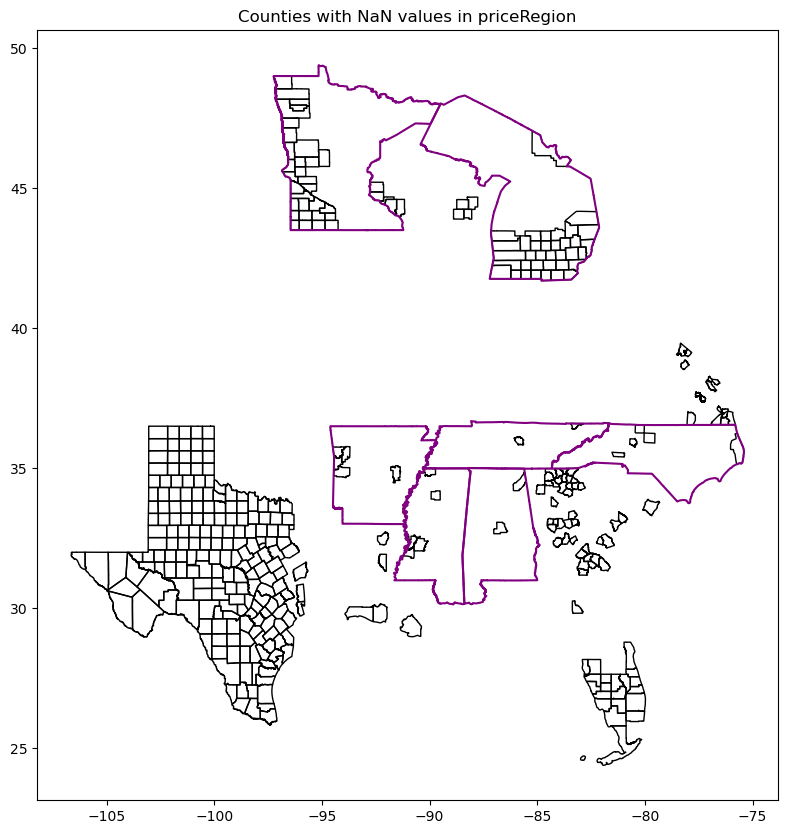

In [29]:
# draw a map of the counties with NaN values in priceRegion
# use cartopy to draw the map

# define the states included in the pilots as pilotStates; use state_abbr
pilotStates = ['MI', 'MN', 'WI', 'TX', 'LA', 'MS',
                'AL', 'FL', 'GA', 'SC', 'NC', 'VA', 'TN', 'AR']


# load counties shapefile
counties = ee.FeatureCollection('TIGER/2018/Counties')
states = ee.FeatureCollection('TIGER/2018/States').filter(
    ee.Filter.inList('STUSPS', pilotStates))

# Define a function to extract the geometries as GeoJSON
def extract_geojson(fc):
    features = fc.getInfo()['features']
    return {
        'type': 'FeatureCollection',
        'features': features
    }

# clip the counties to the pilot states as pilotCounties
pilotCounties = counties.filter(ee.Filter.inList('STATEFP', pilotStates))

# Convert the FeatureCollection to GeoJSON
geojson_states = extract_geojson(states)
geojson_counties = extract_geojson(counties)

# Use GeoPandas to read the GeoJSON data
gdf = gpd.GeoDataFrame.from_features(geojson_counties['features'])
gdf.set_crs(epsg=4326, inplace=True)

# filter GEOID in the geojson_counties data where priceRegion is NaN in concat_df
gdf = gdf[gdf['GEOID'].isin(concat_df[concat_df['priceRegion'].isna()]['fips'])]

# Create a new plot with Cartopy
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the counties
gdf.plot(ax=ax, edgecolor='black', facecolor='none',)

# add state boundaries from geojson_states

gdf_states = gpd.GeoDataFrame.from_features(geojson_states['features'])
gdf_states.set_crs(epsg=4326, inplace=True)
gdf_states.boundary.plot(ax=ax, color='purple')

# Set plot title
plt.title('Counties with NaN values in priceRegion')

# Show the plot
plt.show()